In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import lusee_sky

In [55]:
wf=np.load('waterfalls/wfall_1.0_50.0_0.25_3.0_30.0.npz',allow_pickle=True)['wfall']
## for this, let's merge them. In other words, 11 nights worht of observations in one go
wf=np.vstack(wf)
freq = np.arange(1,50,0.25)
assert(len(freq)==wf.shape[1])

minfreq=1.
maxfreq=30.

i=int((minfreq-freq[0])/0.25)
j=int((maxfreq-freq[0])/0.25)
freq = freq[i:j+1]
print(i,j)
wf = wf[:,i:j+1]
wf.shape
gsignal = lusee_sky.get_signal(freq)

0 116


[]

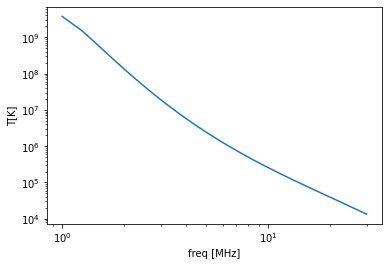

In [59]:
plt.plot(freq,wf.mean(axis=0))
plt.xlabel('freq [MHz]')
plt.ylabel('T[K]')
plt.loglog()

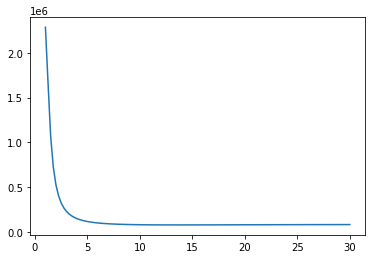

In [56]:
we = (freq/freq[len(freq)//2])**2.70
wfw = wf*we[None,:]
plt.plot(freq,wfw.mean(axis=0))


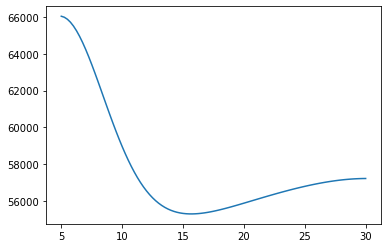

In [41]:
wfw = scipy.ndimage.gaussian_filter(wfw,[0,12])
plt.plot(freq,wfw.mean(axis=0))

In [42]:
cov_from_mean_subtracted = True
print(wfw.shape)
if cov_from_mean_subtracted:
    wfw_nomean =  wfw-wfw.mean(axis=0)
    cov = np.cov(wfw_nomean,rowvar=False)
else:
    cov = np.array([np.outer(t,t) for t in wfw]).mean(axis=0)

(16960, 101)


In [43]:
eva,evec = np.linalg.eigh(cov)
endx = np.argsort(eva)[::-1]

[]

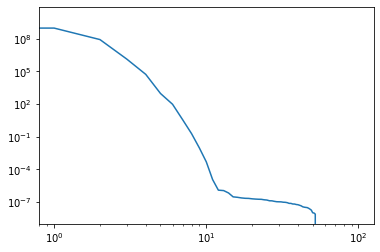

In [44]:
plt.plot(eva[endx])
plt.loglog()

(-0.25, 0.25)

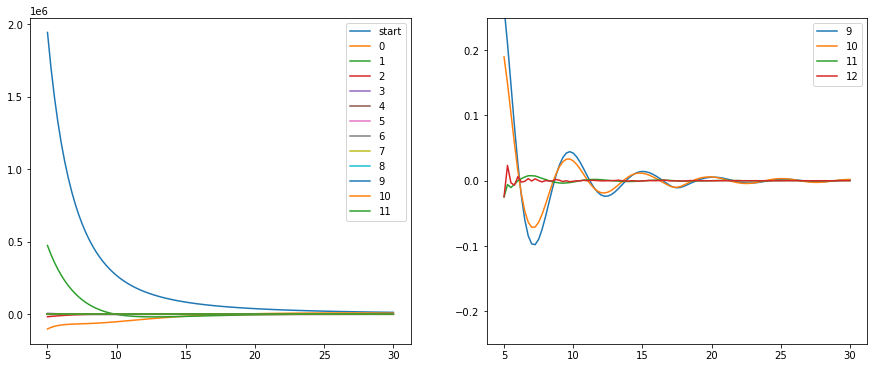

In [51]:
tosub = wfw.copy()
Nmax=12
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,6))
ax1.plot(freq,tosub.mean(axis=0)/we,label='start')
for ii,ndx in enumerate(endx[:Nmax]):
    vec = evec[:,ndx]
    norm = np.dot(vec,vec)
    wex = (tosub*vec[None,:]).sum(axis=1)/norm
    tosub -= np.outer(wex,vec)
    weare = tosub.mean(axis=0)
    ax1.plot(freq, weare/we,label=str(ii))
    if ii>Nmax-5:
        ax2.plot(freq, weare/we,label=str(ii+1))

ax1.legend()
ax2.legend()
ax2.set_ylim(-0.25,0.25)

(-0.01, 0.01)

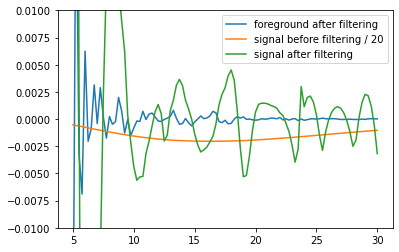

In [54]:
gsigwe = gsignal*we
plt.plot(freq,weare/we,label='foreground after filtering')
plt.plot(freq,gsigwe/we/20, label='signal before filtering / 20')
for ii,ndx in enumerate(endx[:Nmax]):
    vec = evec[:,ndx]
    norm = np.dot(vec,vec)
    wex = np.dot(gsigwe,vec)/norm
    gsigwe -= wex*vec
    
plt.plot(freq,gsigwe/we*100, label='signal after filtering')
plt.legend()
plt.ylim(-0.01,0.01)